<a href="https://colab.research.google.com/github/Dikshitha34/HWR-System/blob/main/%E2%9C%85CRNN_AlexNet%2BBi_LSTM%2BSGDM_executing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing the dataset(From the IAM website)

In [ ]:
!wget -q https://git.io/J0fjL -O IAM_Words.zip

Unzipping the data and creating a folder

In [ ]:
!unzip -qq IAM_Words.zip
!mkdir data
!mkdir data/words
!tar -xf IAM_Words/words.tgz -C data/words
!mv IAM_Words/words.txt data

In [ ]:
!head -20 data/words.txt

#--- words.txt ---------------------------------------------------------------#
#
# iam database word information
#
# format: a01-000u-00-00 ok 154 1 408 768 27 51 AT A
#
#     a01-000u-00-00  -> word id for line 00 in form a01-000u
#     ok              -> result of word segmentation
#                            ok: word was correctly
#                            er: segmentation of word can be bad
#
#     154             -> graylevel to binarize the line containing this word
#     1               -> number of components for this word
#     408 768 27 51   -> bounding box around this word in x,y,w,h format
#     AT              -> the grammatical tag for this word, see the
#                        file tagset.txt for an explanation
#     A               -> the transcription for this word
#
a01-000u-00-00 ok 154 408 768 27 51 AT A
a01-000u-00-01 ok 154 507 766 213 48 NN MOVE


Importing libraries

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
from tensorflow import keras
from keras.layers import *
from keras import backend as K

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

np.random.seed(42)
tf.random.set_seed(42)

Making a list of words

In [ ]:
base_path = "data"
words_list = []

words = open(f"{base_path}/words.txt", "r").readlines()
for line in words:
    if line[0] == "#":
        continue
    if line.split(" ")[1] != "err":
        words_list.append(line)

len(words_list)

np.random.shuffle(words_list)

Splitting into train, test and validation sets

In [ ]:
split_idx = int(0.9 * len(words_list))
train_samples = words_list[:split_idx]
test_samples = words_list[split_idx:]

val_split_idx = int(0.5 * len(test_samples))
validation_samples = test_samples[:val_split_idx]
test_samples = test_samples[val_split_idx:]

assert len(words_list) == len(train_samples) + len(validation_samples) + len(
    test_samples
)

print(f"Total training samples: {len(train_samples)}")
print(f"Total validation samples: {len(validation_samples)}")
print(f"Total test samples: {len(test_samples)}")

Total training samples: 86810
Total validation samples: 4823
Total test samples: 4823


Pre-processing to get the image path

In [ ]:
base_image_path = os.path.join(base_path, "words")

def get_image_paths_and_labels(samples):
    paths = []
    corrected_samples = []
    for (i, file_line) in enumerate(samples):
        line_split = file_line.strip()
        line_split = line_split.split(" ")
        image_name = line_split[0]
        partI = image_name.split("-")[0]
        partII = image_name.split("-")[1]
        img_path = os.path.join(
            base_image_path, partI, partI + "-" + partII, image_name + ".png"
        )
        if os.path.getsize(img_path):
            paths.append(img_path)
            corrected_samples.append(file_line.split("\n")[0])

    return paths, corrected_samples


train_img_paths, train_labels = get_image_paths_and_labels(train_samples)
validation_img_paths, validation_labels = get_image_paths_and_labels(validation_samples)
test_img_paths, test_labels = get_image_paths_and_labels(test_samples)


Finding the maximum length

In [ ]:
train_labels_cleaned = []
characters = set()
max_len = 0

for label in train_labels:
    label = label.split(" ")[-1].strip()
    for char in label:
        characters.add(char)

    max_len = max(max_len, len(label))
    train_labels_cleaned.append(label)

characters = sorted(list(characters))

print("Maximum length: ", max_len)
print("Vocab size: ", len(characters))

train_labels_cleaned[:10]

Maximum length:  21
Vocab size:  78


['sure',
 'he',
 'during',
 'of',
 'booty',
 'gastronomy',
 'boy',
 'The',
 'and',
 'in']

Cleaning the labels for validation and test set

In [ ]:
def clean_labels(labels):
    cleaned_labels = []
    for label in labels:
        label = label.split(" ")[-1].strip()
        cleaned_labels.append(label)
    return cleaned_labels


validation_labels_cleaned = clean_labels(validation_labels)
test_labels_cleaned = clean_labels(test_labels)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

# Mapping characters to integers.
char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)

# Mapping integers back to original characters.
num_to_char = StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

Pre-Processing

In [ ]:
def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0, 0],
        ],
    )

    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image

In [ ]:
batch_size = 64
padding_token = 99
image_width = 128
image_height = 32


def preprocess_image(image_path, img_size=(image_width, image_height)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image

def vectorize_label(label):
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    length = tf.shape(label)[0]
    pad_amount = max_len - length
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
    return label


def process_images_labels(image_path, label):
    image = preprocess_image(image_path)
    label = vectorize_label(label)
    return {"image": image, "label": label}


def prepare_dataset(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)

Preparing the dataset

In [ ]:
train_ds = prepare_dataset(train_img_paths, train_labels_cleaned)
validation_ds = prepare_dataset(validation_img_paths, validation_labels_cleaned)
test_ds = prepare_dataset(test_img_paths, test_labels_cleaned)

Plotting graph for train data

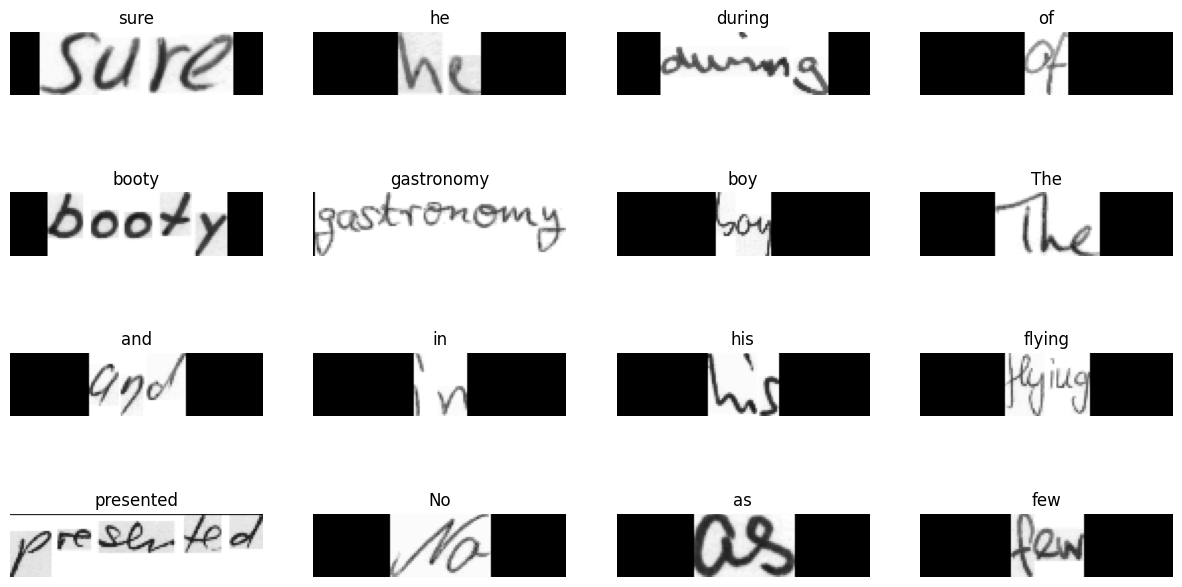

In [ ]:
for data in train_ds.take(1):
    images, labels = data["image"], data["label"]

    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    for i in range(16):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")

        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")


plt.show()

In [ ]:
validation_images = []
validation_labels = []

for batch in validation_ds:
    validation_images.append(batch["image"])
    validation_labels.append(batch["label"])

Edit Distance

In [ ]:
def calculate_edit_distance(labels, predictions):
    # Get a single batch and convert its labels to sparse tensors.
    saprse_labels = tf.cast(tf.sparse.from_dense(labels), dtype=tf.int64)

    # Make predictions and convert them to sparse tensors.
    input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
    predictions_decoded = keras.backend.ctc_decode(
        predictions, input_length=input_len, greedy=True
    )[0][0][:, :max_len]
    sparse_predictions = tf.cast(
        tf.sparse.from_dense(predictions_decoded), dtype=tf.int64
    )

    # Compute individual edit distances and average them out.
    edit_distances = tf.edit_distance(
        sparse_predictions, saprse_labels, normalize=False
    )
    return tf.reduce_mean(edit_distances)


class EditDistanceCallback(keras.callbacks.Callback):
    def __init__(self, pred_model):
        super().__init__()
        self.prediction_model = pred_model

    def on_epoch_end(self, epoch, logs=None):
        edit_distances = []

        for i in range(len(validation_images)):
            labels = validation_labels[i]
            predictions = self.prediction_model.predict(validation_images[i])
            edit_distances.append(calculate_edit_distance(labels, predictions).numpy())

        print(
            f"  Mean edit distance for epoch {epoch + 1}: {np.mean(edit_distances):.4f}"
        )


Model building - CRNN

In [ ]:
class CTCLayer(keras.layers.Layer):
  def __init__(self, name=None):
      super().__init__(name=name)
      self.loss_fn = keras.backend.ctc_batch_cost

  def call(self, y_true, y_pred):
      batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
      input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
      label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

      input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
      label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
      loss = self.loss_fn(y_true, y_pred, input_length, label_length)
      self.add_loss(loss)

      return y_pred

def build_model():
  input_img = keras.Input(shape=(image_width, image_height, 1), name="image")
  labels = keras.layers.Input(name="label", shape=(None,))

  # CNN
  # First conv block.
  x = keras.layers.Conv2D(
      32,
      (3, 3),
      activation="relu",
      kernel_initializer="he_normal",
      padding="same",
      name="Conv1",
  )(input_img)
  x = keras.layers.MaxPooling2D((2, 2), name="Pool1")(x)

  # Second conv block.
  x = keras.layers.Conv2D(
      64,
      (3, 3),
      activation="relu",
      kernel_initializer="he_normal",
      padding="same",
      name="Conv2",
  )(x)
  x = keras.layers.MaxPooling2D((2, 2), name="Pool2")(x)

    # Third conv block.
  x = keras.layers.Conv2D(
      64,
      (3, 3),
      activation="relu",
      kernel_initializer="he_normal",
      padding="same",
      name="Conv3",
  )(x)

    # Fourth conv block
  x = keras.layers.Conv2D(
      64,
      (3, 3),
      activation="relu",
      kernel_initializer="he_normal",
      padding="same",
      name="Conv4",
  )(x)

  new_shape = ((image_width // 4), (image_height // 4) * 64)
  x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
  x = keras.layers.Dense(64, activation="relu", name="dense1")(x)
  x = keras.layers.Dropout(0.2)(x)

  # RNN.
  x = keras.layers.Bidirectional(
      keras.layers.LSTM(128, return_sequences=True, dropout=0.25)  #dropout to prevent overfitting
  )(x)
  x = keras.layers.Bidirectional(
      keras.layers.LSTM(64, return_sequences=True, dropout=0.25)
  )(x)

  x = keras.layers.Dense(
      len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense2"
  )(x)

  output = CTCLayer(name="ctc_loss")(labels, x)

  model = keras.models.Model(
      inputs=[input_img, labels], outputs=output, name="handwriting_recognizer"
  )

  opt = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
  model.compile(optimizer=opt, metrics=['accuracy'])
  # Compile the model and return.
  model.compile(optimizer=opt,metrics=[keras.metrics.Accuracy()])
  return model

# Get the model.
model = build_model()
model.summary()

Model: "handwriting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 128, 32, 1)]         0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 128, 32, 32)          320       ['image[0][0]']               
                                                                                                  
 Pool1 (MaxPooling2D)        (None, 64, 16, 32)           0         ['Conv1[0][0]']               
                                                                                                  
 Conv2 (Conv2D)              (None, 64, 16, 64)           18496     ['Pool1[0][0]']               
                                                                             

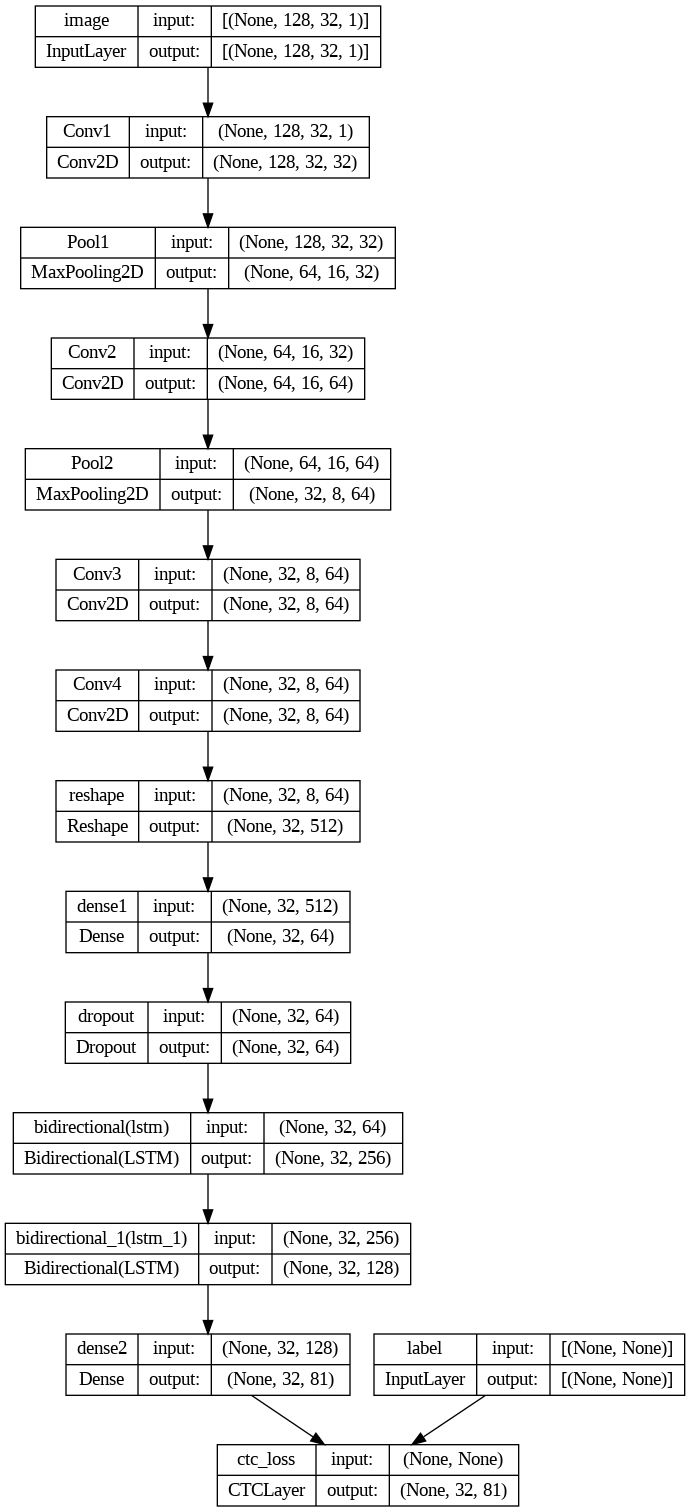

In [ ]:
tf.keras.utils.plot_model(model,show_layer_activations = True)

tf.keras.utils.plot_model(model, show_shapes=True)


Model training - CRNN

In [ ]:
!mkdir -p saved_model_CRNN

In [ ]:
epochs = 12 #240

model = build_model()
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
edit_distance_callback = EditDistanceCallback(prediction_model) #callbacks are the special utilities or functions that are executed during training at given stages of the training procedure.
                                                                # Callbacks helps in preventing overfitting, visualize training progress, debug your code, save checkpoints, generate logs etc
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs,
    callbacks=[edit_distance_callback],
)
model.save('saved_model_CRNN/model')

Epoch 1/12
1/1 [==============================] - 2s 2s/step
  Mean edit distance for epoch 1: 20.9415
1357/1357 [==============================] - 142s 96ms/step - loss: 384.2280 - accuracy: 0.0000e+00 - val_loss: 382.1957 - val_accuracy: 0.0000e+00
Epoch 2/12
1/1 [==============================] - 0s 24ms/step
  Mean edit distance for epoch 2: 20.9415
1357/1357 [==============================] - 73s 54ms/step - loss: 384.8307 - accuracy: 0.0000e+00 - val_loss: 382.1957 - val_accuracy: 0.0000e+00
Epoch 3/12
1/1 [==============================] - 0s 23ms/step
  Mean edit distance for epoch 3: 20.9415
1357/1357 [==============================] - 72s 53ms/step - loss: 384.8307 - accuracy: 0.0000e+00 - val_loss: 382.1957 - val_accuracy: 0.0000e+00
Epoch 4/12
1/1 [==============================] - 0s 23ms/step
  Mean edit distance for epoch 4: 20.9415
1357/1357 [==============================] - 74s 55ms/step - loss: 384.8307 - accuracy: 0.0000e+00 - val_loss: 382.1957 - val_accuracy: 0.00

In [ ]:
!zip -r /content/saved_model_CRNN.zip /content/saved_model_CRNN

  adding: content/saved_model_CRNN/ (stored 0%)
  adding: content/saved_model_CRNN/model/ (stored 0%)
  adding: content/saved_model_CRNN/model/variables/ (stored 0%)
  adding: content/saved_model_CRNN/model/variables/variables.index (deflated 66%)
  adding: content/saved_model_CRNN/model/variables/variables.data-00000-of-00001 (deflated 50%)
  adding: content/saved_model_CRNN/model/fingerprint.pb (stored 0%)
  adding: content/saved_model_CRNN/model/assets/ (stored 0%)
  adding: content/saved_model_CRNN/model/saved_model.pb (deflated 90%)
  adding: content/saved_model_CRNN/model/keras_metadata.pb (deflated 93%)


In [ ]:
!unzip /content/saved_model_CRNN.zip

Archive:  /content/saved_model_CRNN.zip
   creating: content/saved_model_CRNN/
   creating: content/saved_model_CRNN/model/
   creating: content/saved_model_CRNN/model/variables/
  inflating: content/saved_model_CRNN/model/variables/variables.index  
  inflating: content/saved_model_CRNN/model/variables/variables.data-00000-of-00001  
 extracting: content/saved_model_CRNN/model/fingerprint.pb  
   creating: content/saved_model_CRNN/model/assets/
  inflating: content/saved_model_CRNN/model/saved_model.pb  
  inflating: content/saved_model_CRNN/model/keras_metadata.pb  


In [ ]:
model = tf.keras.models.load_model('/content/content/saved_model_CRNN/model')

In [ ]:
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
edit_distance_callback = EditDistanceCallback(prediction_model)

Testing the model and plotting the results - CRNN

2/2 [==============================] - 1s 9ms/step


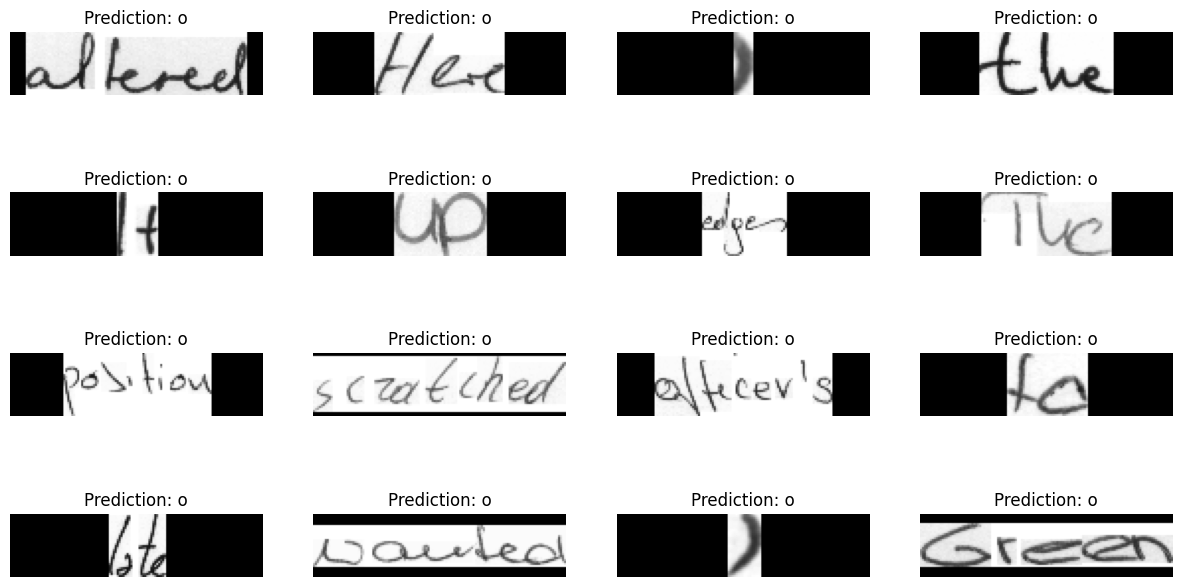

Accuracy of CRNN:  0.0


In [ ]:
results = []
actual_labels = []
count = 0

def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:, :max_len]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

for batch in test_ds.take(1):
    batch_images,act_labels = batch["image"],batch['label']

    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for j in range(len(act_labels)):
        label = act_labels[j]
        ind = tf.gather(label,tf.where(tf.math.not_equal(label,padding_token)))
        label = tf.strings.reduce_join(num_to_char(ind))
        label = label.numpy().decode('utf-8')
        actual_labels.append(label)

    for i in range(16):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]


        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

plt.show()
for i in range(len(actual_labels)):
  if pred_texts[i] == actual_labels[i]:
    count += 1
accuracy = (count / len(pred_texts)) * 100
print('Accuracy of CRNN: ',accuracy)

Model building - AlexNet

In [ ]:
def build_model_alex():
  input_img = keras.Input(shape=(image_width, image_height, 1), name="image")
  labels = keras.layers.Input(name="label", shape=(None,))

  x = keras.layers.Conv2D(
      32,
      (3, 3),
      activation="relu",
      kernel_initializer="he_normal",
      padding="same",
      name="Conv1",
  )(input_img)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.MaxPooling2D((2, 2), name="Pool1")(x)

  # Second conv block.
  x = keras.layers.Conv2D(
      64,
      (3, 3),
      activation="relu",
      kernel_initializer="he_normal",
      padding="same",
      name="Conv2",
  )(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.MaxPooling2D((2, 2), name="Pool2")(x)

    # Third conv block.
  x = keras.layers.Conv2D(
      64,
      (3, 3),
      activation="relu",
      kernel_initializer="he_normal",
      padding="same",
      name="Conv3",
  )(x)
  x = keras.layers.BatchNormalization()(x)

  x = keras.layers.Conv2D(
      64,
      (3, 3),
      activation="relu",
      kernel_initializer="he_normal",
      padding="same",
      name="Conv4",
  )(x)
  x = keras.layers.BatchNormalization()(x)

  new_shape = ((image_width // 4), (image_height // 4) * 64)
  x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
  x = keras.layers.Dense(64, activation="relu", name="dense1")(x)
  x = keras.layers.Dropout(0.2)(x)

  x = keras.layers.Dense(
      len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense2"
  )(x)

  output = CTCLayer(name="ctc_loss")(labels, x)

  model = keras.models.Model(
      inputs=[input_img, labels], outputs=output, name="handwriting_recognizer"
  )
  opt = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
  # Compile the model and return.
  model.compile(optimizer=opt)
  return model

# Get the model.
model_alex = build_model_alex()
model_alex.summary()

Model: "handwriting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 128, 32, 1)]         0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 128, 32, 32)          320       ['image[0][0]']               
                                                                                                  
 batch_normalization (Batch  (None, 128, 32, 32)          128       ['Conv1[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 Pool1 (MaxPooling2D)        (None, 64, 16, 32)           0         ['batch_n

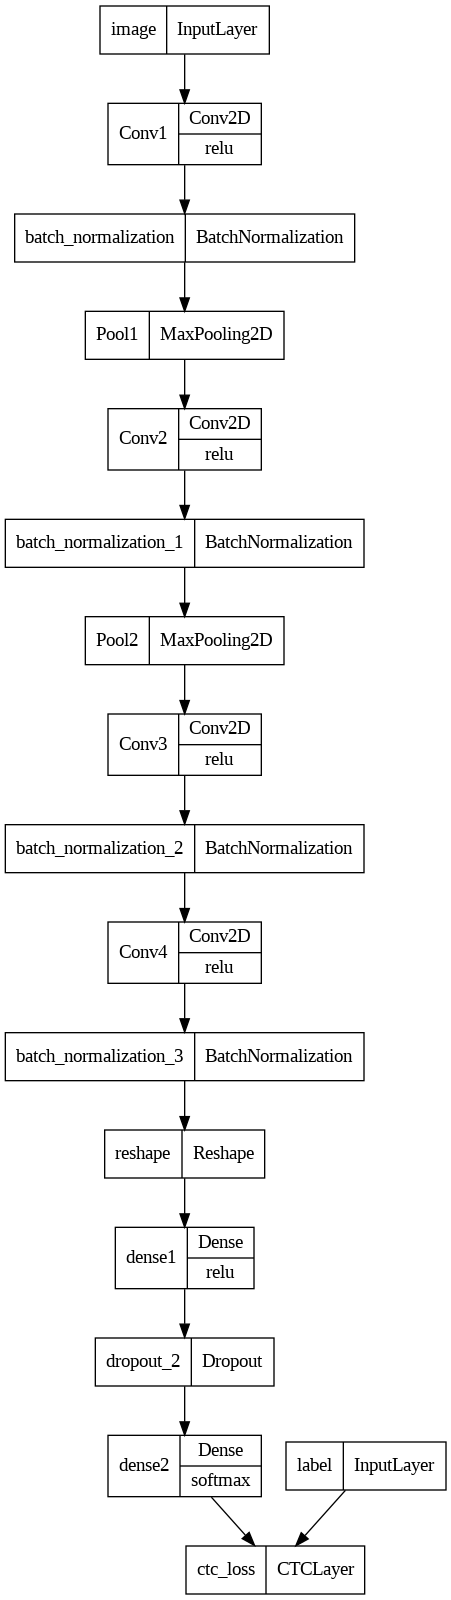

In [ ]:
tf.keras.utils.plot_model(model_alex,show_layer_activations = True)

Model training - AlexNet

In [ ]:
!mkdir -p saved_model_AlexNet

In [ ]:
epochs = 25

model_alex = build_model_alex()
prediction_model_alex = keras.models.Model(
    model_alex.get_layer(name="image").input, model_alex.get_layer(name="dense2").output
)
edit_distance_callback = EditDistanceCallback(prediction_model_alex)

history_alex = model_alex.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs,
    callbacks=[edit_distance_callback],
)
#model.save('saved_model_AlexNet/model')

Epoch 1/25
1/1 [==============================] - 0s 186ms/step
  Mean edit distance for epoch 1: 21.0000
1357/1357 [==============================] - 68s 49ms/step - loss: 57.3085 - val_loss: 57.8501
Epoch 2/25
1/1 [==============================] - 0s 19ms/step
  Mean edit distance for epoch 2: 21.0000
1357/1357 [==============================] - 65s 48ms/step - loss: 57.2570 - val_loss: 57.8501
Epoch 3/25
1/1 [==============================] - 0s 22ms/step
  Mean edit distance for epoch 3: 21.0000
1357/1357 [==============================] - 67s 49ms/step - loss: 57.2570 - val_loss: 57.8501
Epoch 4/25
1/1 [==============================] - 0s 18ms/step
  Mean edit distance for epoch 4: 21.0000
1357/1357 [==============================] - 65s 48ms/step - loss: 57.2570 - val_loss: 57.8501
Epoch 5/25
1/1 [==============================] - 0s 18ms/step
  Mean edit distance for epoch 5: 21.0000
1357/1357 [==============================] - 65s 48ms/step - loss: 57.2570 - val_loss: 57.8501

In [ ]:
!zip -r /content/saved_model_AlexNet.zip /content/saved_model_AlexNet

  adding: content/saved_model_AlexNet/ (stored 0%)


Graphs - AlexNet

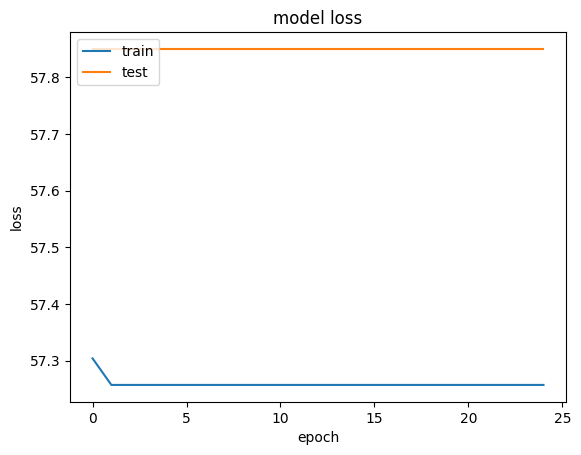

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history_alex.history['loss'])
plt.plot(history_alex.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Testing the model and plotting the results - AlexNet

2/2 [==============================] - 0s 5ms/step


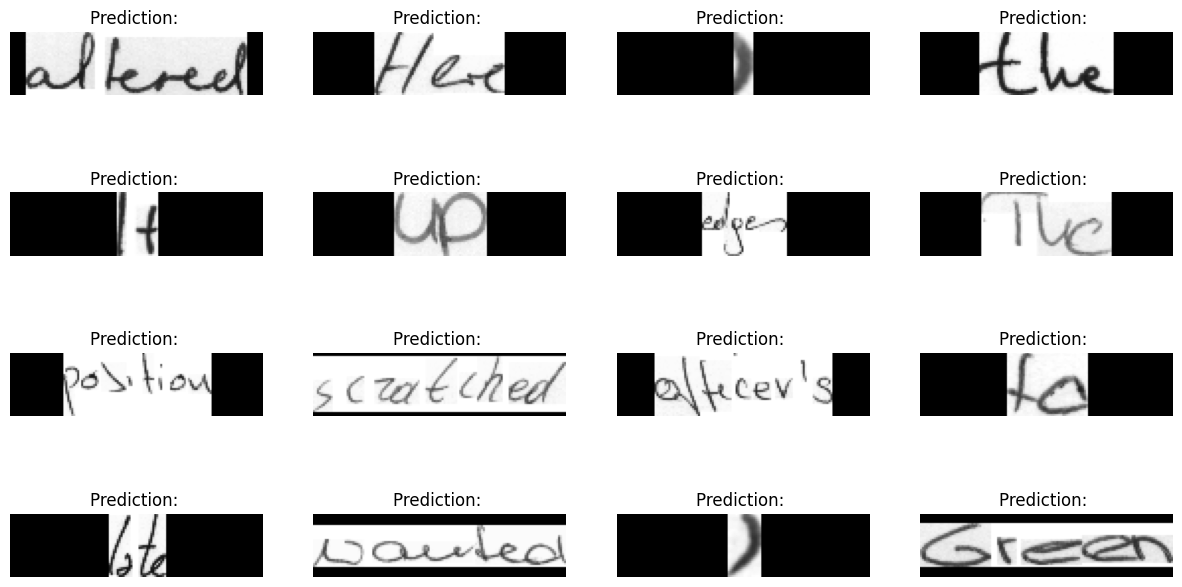

Accuracy of AlexNet:  0.0


In [ ]:
results_alex = []
actual_labels_alex = []
count_alex = 0

def decode_batch_predictions_alex(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:, :max_len]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

for batch in test_ds.take(1):
    batch_images,act_labels_alex = batch["image"],batch['label']
    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    preds_alex = prediction_model_alex.predict(batch_images)
    pred_texts_alex = decode_batch_predictions_alex(preds_alex)

    for j in range(len(act_labels_alex)):
        label = act_labels_alex[j]
        ind = tf.gather(label,tf.where(tf.math.not_equal(label,padding_token)))
        label = tf.strings.reduce_join(num_to_char(ind))
        label = label.numpy().decode('utf-8')
        actual_labels_alex.append(label)


    for i in range(16):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"Prediction: {pred_texts_alex[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

plt.show()
for i in range(len(actual_labels_alex)):
  if pred_texts_alex[i] == actual_labels_alex[i]:
    count_alex += 1
accuracy_alex = (count_alex / len(pred_texts_alex)) * 100
print('Accuracy of AlexNet: ',accuracy_alex)

Testing real time - CRNN

1/1 [==============================] - 0s 31ms/step


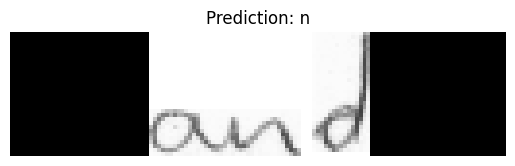

In [ ]:
test_img = "/content/and.png"
t = test_img.split('.')
img_paths = ['png','jpg','jpeg','apng','avif','gif','svg']
if t[-1] in img_paths:
  test_img_pre = preprocess_image(test_img)
  pred = prediction_model.predict(np.array([test_img_pre,]))
  len = np.ones(pred.shape[0]) * pred.shape[1]
  res = keras.backend.ctc_decode(pred, input_length=len, greedy=True)[0][0][:, :max_len]
  for r in res:
    r = tf.gather(r, tf.where(tf.math.not_equal(r, -1)))
    r = tf.strings.reduce_join(num_to_char(r)).numpy().decode("utf-8")

  _,ax = plt.subplots()
  img = tf.image.flip_left_right(test_img_pre)
  img = tf.transpose(img, perm=[1, 0, 2])
  img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
  img = img[:, :, 0]
  title = f"Prediction: {r}"
  ax.imshow(img, cmap="gray")
  ax.set_title(title)
  ax.axis("off")

  plt.show()
else:
  print('Invalid input format! Only image is accepted as input.')

1/1 [==============================] - 0s 20ms/step


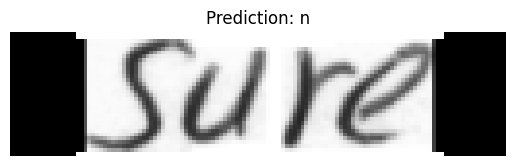

In [ ]:
test_img = '/content/sure.png'
t = test_img.split('.')
img_paths = ['png','jpg','jpeg','apng','avif','gif','svg']
if t[-1] in img_paths:
  test_img_pre = preprocess_image(test_img)
  pred = prediction_model.predict(np.array([test_img_pre,]))
  len = np.ones(pred.shape[0]) * pred.shape[1]
  res = keras.backend.ctc_decode(pred, input_length=len, greedy=True)[0][0][:, :max_len]
  for r in res:
    r = tf.gather(r, tf.where(tf.math.not_equal(r, -1)))
    r = tf.strings.reduce_join(num_to_char(r)).numpy().decode("utf-8")

  _,ax = plt.subplots()
  img = tf.image.flip_left_right(test_img_pre)
  img = tf.transpose(img, perm=[1, 0, 2])
  img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
  img = img[:, :, 0]
  title = f"Prediction: {r}"
  ax.imshow(img, cmap="gray")
  ax.set_title(title)
  ax.axis("off")

  plt.show()
else:
  print('Invalid input format! Only image is accepted as input.')

In [ ]:
test_img = '/content/bonjour.jpg'
t = test_img.split('.')
img_paths = ['png','jpg','jpeg','apng','avif','gif','svg']
if t[-1] in img_paths:
  test_img_pre = preprocess_image(test_img)
  pred = prediction_model.predict(np.array([test_img_pre,]))
  len = np.ones(pred.shape[0]) * pred.shape[1]
  res = keras.backend.ctc_decode(pred, input_length=len, greedy=True)[0][0][:, :max_len]
  for r in res:
    r = tf.gather(r, tf.where(tf.math.not_equal(r, -1)))
    r = tf.strings.reduce_join(num_to_char(r)).numpy().decode("utf-8")

  _,ax = plt.subplots()
  img = tf.image.flip_left_right(test_img_pre)
  img = tf.transpose(img, perm=[1, 0, 2])
  img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
  img = img[:, :, 0]
  title = f"Prediction: {r}"
  ax.imshow(img, cmap="gray")
  ax.set_title(title)
  ax.axis("off")

  plt.show()
else:
  print('Invalid input format! Only image is accepted as input.')

NotFoundError: {{function_node __wrapped__ReadFile_device_/job:localhost/replica:0/task:0/device:CPU:0}} /content/bonjour.jpg; No such file or directory [Op:ReadFile]

1/1 [==============================] - 0s 21ms/step


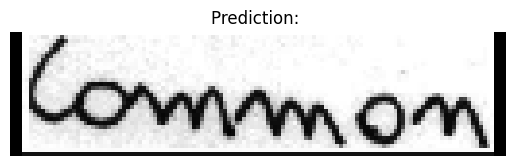

In [ ]:
test_img = '/content/Screenshot 2024-02-01 174825.png'
t = test_img.split('.')
img_paths = ['png','jpg','jpeg','apng','avif','gif','svg']
if t[-1] in img_paths:
  test_img_pre = preprocess_image(test_img)
  pred = prediction_model.predict(np.array([test_img_pre,]))
  len = np.ones(pred.shape[0]) * pred.shape[1]
  res = keras.backend.ctc_decode(pred, input_length=len, greedy=True)[0][0][:, :max_len]
  for r in res:
    r = tf.gather(r, tf.where(tf.math.not_equal(r, -1)))
    r = tf.strings.reduce_join(num_to_char(r)).numpy().decode("utf-8")

  _,ax = plt.subplots()
  img = tf.image.flip_left_right(test_img_pre)
  img = tf.transpose(img, perm=[1, 0, 2])
  img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
  img = img[:, :, 0]
  title = f"Prediction: {r}"
  ax.imshow(img, cmap="gray")
  ax.set_title(title)
  ax.axis("off")

  plt.show()
else:
  print('Invalid input format! Only image is accepted as input.')

1/1 [==============================] - 0s 37ms/step


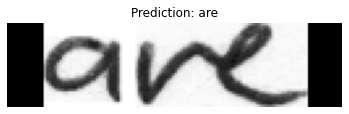

In [ ]:
test_img = '/content/sample10.jpeg'
t = test_img.split('.')
img_paths = ['png','jpg','jpeg','apng','avif','gif','svg']
if t[-1] in img_paths:
  test_img_pre = preprocess_image(test_img)
  pred = prediction_model.predict(np.array([test_img_pre,]))
  len = np.ones(pred.shape[0]) * pred.shape[1]
  res = keras.backend.ctc_decode(pred, input_length=len, greedy=True)[0][0][:, :max_len]
  for r in res:
    r = tf.gather(r, tf.where(tf.math.not_equal(r, -1)))
    r = tf.strings.reduce_join(num_to_char(r)).numpy().decode("utf-8")

  _,ax = plt.subplots()
  img = tf.image.flip_left_right(test_img_pre)
  img = tf.transpose(img, perm=[1, 0, 2])
  img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
  img = img[:, :, 0]
  title = f"Prediction: {r}"
  ax.imshow(img, cmap="gray")
  ax.set_title(title)
  ax.axis("off")

  plt.show()
else:
  print('Invalid input format! Only image is accepted as input.')

Testing real time - AlexNet

1/1 [==============================] - 0s 39ms/step


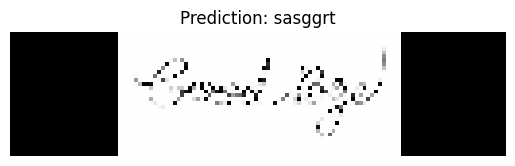

In [ ]:
test_img1 = '/content/good_bye.jpg'
t = test_img1.split('.')
img_paths = ['png','jpg','jpeg','apng','avif','gif','svg']
if t[-1] in img_paths:
  test_img_pre1 = preprocess_image(test_img1)
  pred1 = prediction_model_alex.predict(np.array([test_img_pre1,]))
  len1 = np.ones(pred1.shape[0]) * pred1.shape[1]
  res1 = keras.backend.ctc_decode(pred1, input_length=len1, greedy=True)[0][0][:, :max_len]
  for r in res1:
    r = tf.gather(r, tf.where(tf.math.not_equal(r, -1)))
    r = tf.strings.reduce_join(num_to_char(r)).numpy().decode("utf-8")

  _,ax = plt.subplots()
  img = tf.image.flip_left_right(test_img_pre1)
  img = tf.transpose(img, perm=[1, 0, 2])
  img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
  img = img[:, :, 0]
  title = f"Prediction: {r}"
  ax.imshow(img, cmap="gray")
  ax.set_title(title)
  ax.axis("off")

  plt.show()
else:
  print('Invalid input format! Only image is accepted as input.')

1/1 [==============================] - 0s 17ms/step


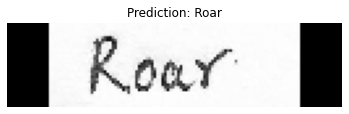

In [ ]:
test_img1 = '/content/sample1.jpeg'
t = test_img1.split('.')
img_paths = ['png','jpg','jpeg','apng','avif','gif','svg']
if t[-1] in img_paths:
  test_img_pre1 = preprocess_image(test_img1)
  pred1 = prediction_model_alex.predict(np.array([test_img_pre1,]))
  len1 = np.ones(pred1.shape[0]) * pred1.shape[1]
  res1 = keras.backend.ctc_decode(pred1, input_length=len1, greedy=True)[0][0][:, :max_len]
  for r in res1:
    r = tf.gather(r, tf.where(tf.math.not_equal(r, -1)))
    r = tf.strings.reduce_join(num_to_char(r)).numpy().decode("utf-8")

  _,ax = plt.subplots()
  img = tf.image.flip_left_right(test_img_pre1)
  img = tf.transpose(img, perm=[1, 0, 2])
  img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
  img = img[:, :, 0]
  title = f"Prediction: {r}"
  ax.imshow(img, cmap="gray")
  ax.set_title(title)
  ax.axis("off")

  plt.show()
else:
  print('Invalid input format! Only image is accepted as input.')

1/1 [==============================] - 0s 23ms/step


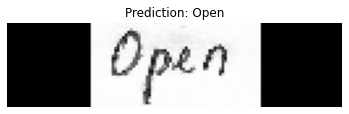

In [ ]:
test_img1 = '/content/sample4.jpeg'
t = test_img1.split('.')
img_paths = ['png','jpg','jpeg','apng','avif','gif','svg']
if t[-1] in img_paths:
  test_img_pre1 = preprocess_image(test_img1)
  pred1 = prediction_model_alex.predict(np.array([test_img_pre1,]))
  len1 = np.ones(pred1.shape[0]) * pred1.shape[1]
  res1 = keras.backend.ctc_decode(pred1, input_length=len1, greedy=True)[0][0][:, :max_len]
  for r in res1:
    r = tf.gather(r, tf.where(tf.math.not_equal(r, -1)))
    r = tf.strings.reduce_join(num_to_char(r)).numpy().decode("utf-8")

  _,ax = plt.subplots()
  img = tf.image.flip_left_right(test_img_pre1)
  img = tf.transpose(img, perm=[1, 0, 2])
  img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
  img = img[:, :, 0]
  title = f"Prediction: {r}"
  ax.imshow(img, cmap="gray")
  ax.set_title(title)
  ax.axis("off")

  plt.show()
else:
  print('Invalid input format! Only image is accepted as input.')